In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import time
from NEF_RL import *
from fit import *

### Carrabin

In [8]:
trial = 1
sid = 1
alpha = 0.25
lambd = 0.0
# lambd = 1.0
alpha_nef = alpha if lambd==0.0 else 1.0

env = EnvironmentRL(dataset='carrabin', sid=sid, trial=trial, alpha=alpha_nef, z=0, lambd=lambd)
net, sim = simulate_RL(env=env, seed_net=sid, progress_bar=True)
B_0 = [get_expectations_carrabin("B_n", [0], sid, trial, stage) for stage in range(1,6)]
RL_0 = [get_expectations_carrabin("RL_n", [alpha, 0], sid, trial, stage) for stage in range(1,6)]
B_0.insert(0, 0)
RL_0.insert(0, 0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

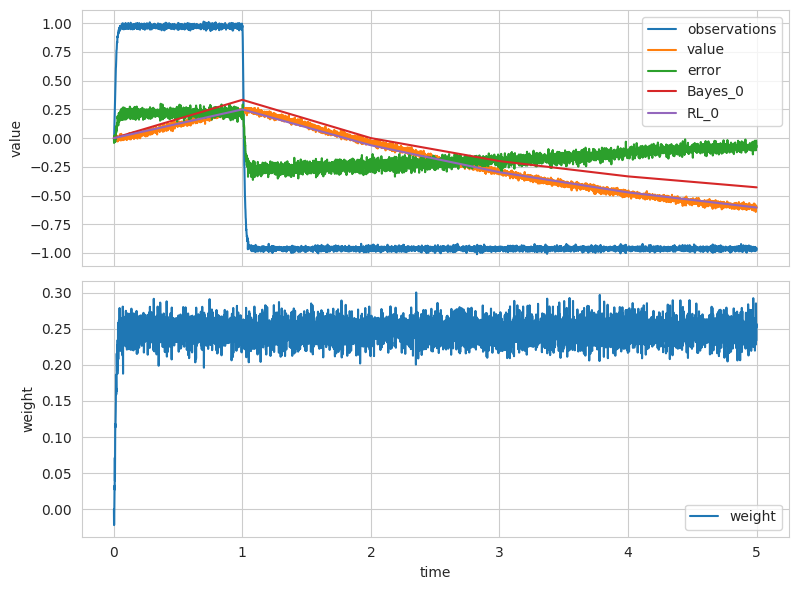

In [9]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input_obs].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
error = sim.data[net.probe_error].flatten()
value = sim.data[net.probe_value].flatten()
obs_times = np.arange(0, 6*env.T, env.T)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)
    sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
    sns.lineplot(x=times, y=value, ax=axes[0], label='value')
    sns.lineplot(x=times, y=error, ax=axes[0], label='error')
    sns.lineplot(x=obs_times, y=B_0, ax=axes[0], label='Bayes_0')
    sns.lineplot(x=obs_times, y=RL_0, ax=axes[0], label='RL_0')
    sns.lineplot(x=times, y=weight, ax=axes[1], label='weight')
    axes[0].set(xlabel='time', ylabel='value')
    axes[1].set(xlabel='time', ylabel='weight', xticks=obs_times)
    plt.tight_layout()

### Jiang

In [6]:
trial = 1
sid = 1
z = 0.5
alpha = 0.25
# lambd = 0.0
lambd = 1.0
alpha_nef = alpha if lambd==0.0 else 1.0

env = EnvironmentRL(dataset='jiang', sid=sid, trial=trial, alpha=alpha_nef, z=z, lambd=lambd)
net, sim = simulate_RL(env=env, seed_net=sid, progress_bar=True)
DGz = get_expectations_jiang("DG_z", [z], sid, trial, stage=3, full=True)
RLz = get_expectations_jiang("RL_z", [alpha, z], sid, trial, stage=3, full=True)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

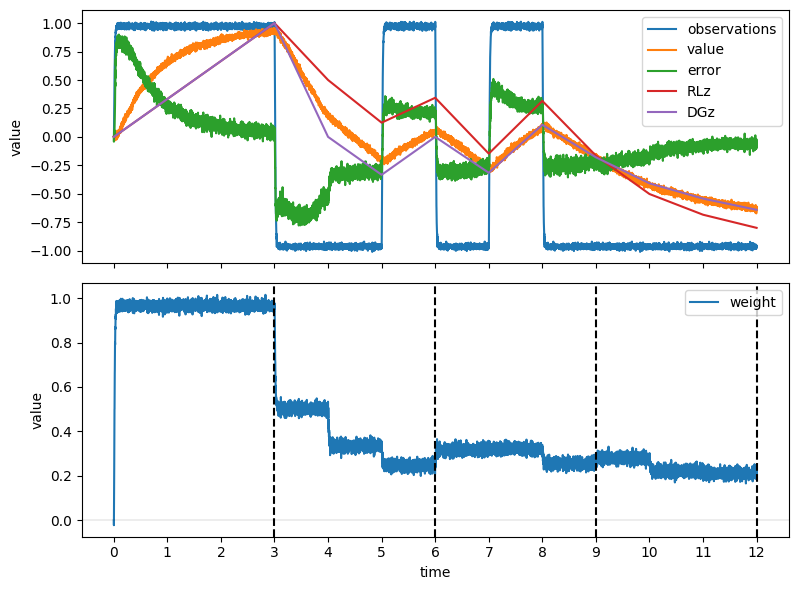

In [7]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input_obs].flatten()
obs = sim.data[net.probe_obs].flatten()
weight = sim.data[net.probe_weight].flatten()
error = sim.data[net.probe_error].flatten()
value = sim.data[net.probe_value].flatten()
obs_times = np.arange(3*env.T, env.T+4*env.n_neighbors*env.T, env.T)
obs_times = list(obs_times)
obs_times.insert(0, 0)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,6), sharex=True)
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=value, ax=axes[0], label='value')
sns.lineplot(x=times, y=error, ax=axes[0], label='error')
sns.lineplot(x=obs_times, y=RLz, ax=axes[0], label='RLz')
sns.lineplot(x=obs_times, y=DGz, ax=axes[0], label='DGz')
sns.lineplot(x=times, y=weight, ax=axes[1], label='weight')
axes[1].axhline(0, color='k', lw=0.1)
axes[1].axvline(3*env.T, color='k', ls='--')
axes[1].axvline(3*env.T+env.n_neighbors*env.T, color='k', ls='--')
axes[1].axvline(3*env.T+2*env.n_neighbors*env.T, color='k', ls='--')
axes[1].axvline(3*env.T+3*env.n_neighbors*env.T, color='k', ls='--')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value', xticks=np.arange(0, env.T+4*env.n_neighbors*env.T, env.T))  # , ylim=(0.0, 0.5)
plt.tight_layout()